# Exercise 9


## 1. Grover's algorithm for two qubits

(a) Implement an oracle and diffusion operator to search all strings of two bits to find `01`.

(b) Run the algorithm, and determine how many iterations are required to output `01` with high probability.

1) check qiskit textbook

2) Find oracle and diffusion operator, to make "grover-part" and repeat is as often as possible.
Hint: Add step at the beginning, that only has effects when repeating.

3) High probability typically means >90%. So find how many grover steps you need to perform to reach this rate.


In [1]:
from qiskit import *
from qiskit.circuit.library import MCMT
sim = Aer.get_backend('aer_simulator')
from qiskit.visualization import array_to_latex, circuit_drawer, plot_histogram
from qiskit.extensions import *
from qiskit.providers.ibmq import least_busy
from matplotlib import pyplot as plt

Our oracle for two wubits and the winning state $|01\rangle$ looks like this, as we have to apply a phase of $-1$ to the winning state: $$U_\omega = (I - |01\rangle\langle01|) - |01\rangle\langle01| = \begin{pmatrix}
1&&0&&0&&0\\
0&&-1&&0&&0\\
0&&0&&1&&0\\
0&&0&&0&&1\\
\end{pmatrix}$$ 

In [16]:
u_f = UnitaryGate([[1,0,0,0],
                   [0,-1,0,0], 
                   [0,0,1,0],
                   [0,0,0,1]])

We now need to be able to implement a general diffuer for $n$ qubits. The diffuser applies a phase of $-1$ to all states that are orthogonal to $|s\rangle$. Because we know that we can transform $|0\rangle \rightarrow |00..0\rangle$ using some Hadamards ($H^{\otimes n} |s\rangle = |00...\rangle$), we can effectively perform a an X on every qubit ($|000...0\rangle \rangle \rightarrow |111..\rangle$ and $|111...1\rangle \rightarrow |000...0\rangle$) and then multicontrolled-Z (applies a phase of $-1$ to $|111...1\rangle$)on the state we get after the hadamards. Then we uncompute the Xs and the Hadamards, which leaves us with $$U_s = H^{\otimes n} X^{\otimes n} MCZ H^{\otimes n} X^{\otimes n}$$.

Because Qiskit does not have a native implementation of the multicontrolled-Z, we can perform a Hadamard on the last qubit, then perform a multicontrolled-X and then a Hadamard again. This works, because the Hadamard transforms the bases.

In [3]:
def diffuser(n_qubits):
    diffuser = QuantumCircuit(n_qubits)

    diffuser.h(list(range(n_qubits)))
    diffuser.x(list(range(n_qubits)))
    
    # way to perform multicontrolled-z in qiskit
    diffuser.h(n_qubits-1)
    diffuser.mct(list(range(n_qubits-1)), n_qubits-1)
    diffuser.h(n_qubits-1)
    
    diffuser.x(list(range(n_qubits)))
    diffuser.h(list(range(n_qubits)))
    diffuser = diffuser.to_gate()
    diffuser.name = "Diffuser"
    return diffuser

The number of repetitions need to be performed is proportional to the $\sqrt N$. To actually show what the best amount of repetitions are, I am going to graph the results, up to 10 repetitions

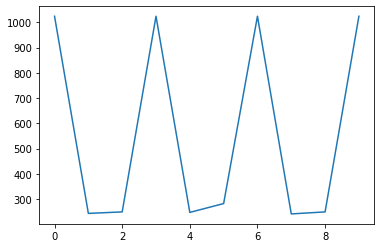

In [17]:
N = 2
results = []
for rep in range(1, 11):
    qc = QuantumCircuit(2)
    qc.h(list(range(N))) # Put qubits into a superposition of all numbers
    for i in range(rep):
        qc.unitary(u_f, list(range(N)), 'Uf') # Apply Grovers Oracle
        qc.append(diffuser(N), list(range(N))) # Apply Diffuser
        
    qc.measure_all() # Measure the qubits
    circ = transpile(qc, sim)
    result = sim.run(circ).result()
    counts = result.get_counts(circ)
    results.append(counts['01'])
plt.plot(results)
plt.show()

From this graph we can see that there is a period of about 1, which makes sense when you think about the amount of times the state is being rotated. Therefore we take the lowest amount of times needed for the ciruit to produce a good result, which in this case is 1:

In [5]:
qc = QuantumCircuit(N)
simulator = Aer.get_backend('aer_simulator')

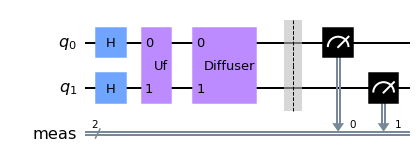

In [6]:
qc.h(list(range(N))) # Put qubits into a superp
for i in range(1):
    qc.unitary(u_f, list(range(N)), 'Uf')
    qc.append(diffuser(N), list(range(N)))
    
qc.measure_all()
qc.draw(output='mpl')

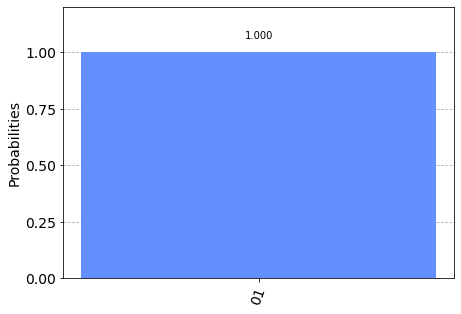

In [7]:
circ = transpile(qc, sim)
result = sim.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts)

## 2. Grover's algorithm for three qubits

(a) Implement an oracle and diffusion operator to search all strings of three bits to find `100`.

(b) Run the algorithm, and determine how many iterations are required to output `100` with high probability.

This thime our oracle is exactly the same, expcept that it's for 3 qubits and it applies a phase of $-1$ to the 3 qubit winning state of $|100\rangle$: $$U_\omega = (I - |100\rangle\langle100|)-|100\rangle\langle100| = \begin{pmatrix}1&&0&&0&&0&&0&&0&&0&&0\\
0&&1&&0&&0&&0&&0&&0&&0\\
0&&0&&1&&0&&0&&0&&0&&0\\
0&&0&&0&&1&&0&&0&&0&&0\\
0&&0&&0&&0&&-1&&0&&0&&0\\
0&&0&&0&&0&&0&&1&&0&&0\\
0&&0&&0&&0&&0&&0&&1&&0\\
0&&0&&0&&0&&0&&0&&0&&1\end{pmatrix}$$

In [8]:
u_f = UnitaryGate([[1, 0, 0, 0, 0, 0, 0, 0],
                   [0, 1, 0, 0, 0, 0, 0, 0],
                   [0, 0, 1, 0, 0, 0, 0, 0],
                   [0, 0, 0, 1, 0, 0, 0, 0],
                   [0, 0, 0, 0,-1, 0, 0, 0],
                   [0, 0, 0, 0, 0, 1, 0, 0],
                   [0, 0, 0, 0, 0, 0, 1, 0],
                   [0, 0, 0, 0, 0, 0, 0, 1]]) # Unitary to apply phase of -1 to |100>

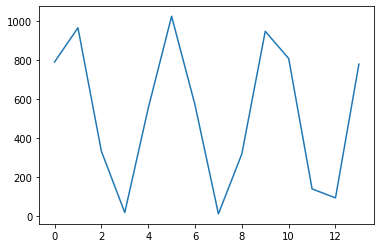

In [9]:
results = []
N = 3
for rep in range(1, 15):
    qc = QuantumCircuit(N)
    qc.h(list(range(N))) # Put qubits into a superposition of all numbers
    for i in range(rep):
        qc.unitary(u_f, list(range(N)), 'Uf')
        qc.append(diffuser(N), list(range(N)))
        
    qc.measure_all()
    circ = transpile(qc, sim)
    result = sim.run(circ).result()
    counts = result.get_counts(circ)
    results.append(counts['100'])
    
plt.plot(results)
plt.show()

We can again see the periodicity of the graph. We again take the lowest amount of repetitions that deliver reasonable results, which in this case is $2$. I have read online that a good approximation the number of repetitions $r$ is $r \leq n \frac\pi4 \sqrt N$, where $r, n\in \mathbb Z$. A good way to find a number of repetetitions $r$ is to find an $n$, such that the expression is as close to real number as possible (minimize $\frac\pi4 \sqrt N - \lfloor{\frac\pi4 \sqrt N}\rfloor$) and then define $r  = \lfloor{\frac\pi4 \sqrt N}\rfloor$.

In [10]:
N = 3
qc = QuantumCircuit(N)

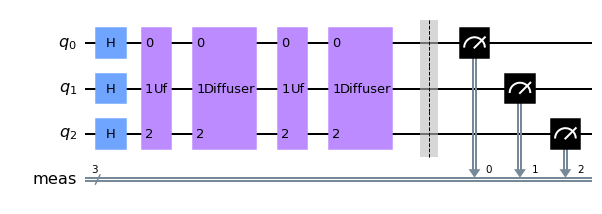

In [11]:
qc.h(list(range(N))) # Put qubits into superpositions of all numbers
for i in range(2): # repeat r times, where r \leq pi/4 sqrt(N)
    qc.unitary(u_f, list(range(N)), 'Uf')
    qc.append(diffuser(N), list(range(N)))
qc.measure_all()
qc.draw(output='mpl')

In [12]:
simulator = Aer.get_backend('aer_simulator')
circ = transpile(qc, sim)

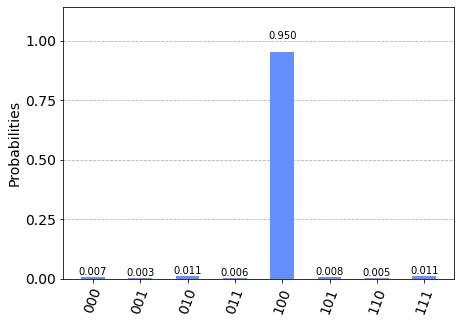

In [13]:
result = sim.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts)